In [9]:
import ee
import os
import re
import csv
import glob
import geemap
import datetime
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
import geopandas as gpd
import matplotlib.colors
from scipy.stats import norm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get today's date and create a directory name in the format "yyyyMMdd"
today = datetime.date.today()
dir_in = today.strftime("%Y%m%d")
out_dir = 'G:/001Project/Output/Figures/' + dir_in + '/'

# Create the output directory if it doesn't exist
# os.makedirs(out_dir, exist_ok=True)

# Check if the directory already exists, and if not, create it
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

## Spatial Aggregation

In [3]:
# Define the path to the CSV files for the section-year using the wildcard (*) to select multiple files that match the pattern.
section_file = 'G:/001Project/Output/Sheets/cleaned_Results/irrigation_wUse/Section_IWU_*.csv'

# Function to process data and return combined DataFrame
def process_data(file_pattern, groupby_column='COUNTY'):
    all_data = []
    for file in glob.glob(file_pattern):
        # Extract the year from the file name
        year = file.split('_')[-1].split('.')[0]
        
        data = pd.read_csv(file)
        model_columns = ['DISALEXI_DAYMET', 'EEMETRIC_DAYMET', 'GEESEBAL_DAYMET', 'PTJPL_DAYMET', 'SIMS_DAYMET', 'SSEBOP_DAYMET',
                         'DISALEXI_gridMET', 'EEMETRIC_gridMET', 'GEESEBAL_gridMET', 'PTJPL_gridMET', 'SIMS_gridMET', 'SSEBOP_gridMET',
                         'DISALEXI_IMERG', 'EEMETRIC_IMERG', 'GEESEBAL_IMERG', 'PTJPL_IMERG', 'SIMS_IMERG', 'SSEBOP_IMERG',
                         'DISALEXI_NLDAS', 'EEMETRIC_NLDAS', 'GEESEBAL_NLDAS', 'PTJPL_NLDAS', 'SIMS_NLDAS', 'SSEBOP_NLDAS',
                         'DISALEXI_PRISM', 'EEMETRIC_PRISM', 'GEESEBAL_PRISM', 'PTJPL_PRISM', 'SIMS_PRISM', 'SSEBOP_PRISM']
        
        # exclude all values less than 0
        data[model_columns] = data[model_columns].clip(lower=0)
        
        # Group by STATE and COUNTY to get the average for each county in a state
        data = data.groupby(['STATE', groupby_column])[model_columns].mean().reset_index()
        
        data['STD'] = data[model_columns].std(axis=1)
        data['Year'] = year
        all_data.append(data)
        
    return pd.concat(all_data)

# Process data for counties
county_data = process_data(section_file, groupby_column='COUNTY')

# Create a 1-row 2-column subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True,  gridspec_kw={'width_ratios': [1.5, 3]})

# Plot County variability on (axes[0])
sns.violinplot(y=county_data[county_data['STD'] < 200]['STD'], width=0.5, inner='quartile', ax=axes[0])
sns.boxplot(data=county_data, y='STD', saturation=0.5, width=0.1,  color='red', boxprops={'zorder': 2}, showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'}, ax=axes[0])
axes[0].set_ylabel('Variability (mm/season)', fontweight='bold')
axes[0].text(0.02, 0.95, '(a)', transform=axes[0].transAxes, fontsize=15, fontweight='bold')

# Calculate statistics for county_data
county_stats = county_data['STD'].describe()
county_mean = county_stats['mean']
county_std = county_stats['std']
county_median = county_stats['50%']  # Equivalent to the median
county_q1 = county_stats['25%']  # First quartile (Q1)
county_q3 = county_stats['75%']  # Third quartile (Q3)
county_min = county_stats['min']  # Minimum value
county_max =county_stats['max']  # Maximum value

# Add labels for mean, interquartile ranges on the top right of the first plot
axes[0].text(0.55, 0.90, f'Mean: {county_mean:.2f}', transform=axes[0].transAxes, fontsize=10, fontweight='bold', color='green')
axes[0].text(0.55, 0.85, f'IQR (Q1-Q3): {county_q1:.2f}-{county_q3:.2f}', transform=axes[0].transAxes, fontsize=10, fontweight='bold', color='blue')
axes[0].text(0.55, 0.80, f'Range: {county_min:.2f}-{county_max:.2f}', transform=axes[0].transAxes, fontsize=12, fontweight='bold', color='red')

# Create a data dictionary for the table
table_data = {
    'Year': ['6 Years'],
    'Data': ['Counties'],
    'Mean': [county_mean],
    'Std': [county_std],
    'Median': [county_median],
    'Q1': [county_q1],
    'Q3': [county_q3]
}

# Convert the data dictionary into a DataFrame
table_df = pd.DataFrame(table_data)
table_df = table_df.round(2)

# Display the table
print(table_df)

# Plot county IWU variability on (axes[1])
sns.violinplot(data=county_data, x='Year', y='STD', inner='quartile', ax=axes[1])
sns.boxplot(data=county_data, x='Year', y='STD', width=0.15, color='red', boxprops={'zorder': 2}, showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'}, ax=axes[1])

# Add a horizontal line at the mean
for ax in [axes[0], axes[1]]:
    ax.axhline(y=county_mean, color='green', linestyle='-', label='y=74.22')


axes[1].set_ylabel('') # Hide x-axis label on the first plot
axes[1].set_xlabel('Years', fontweight='bold') 
axes[1].text(0.02, 0.95, '(b)', transform=axes[1].transAxes, fontsize=15, fontweight='bold')

# Add suptitle for the entire figure
fig.suptitle('Inter-model variability in IWU estimates across counties in the HPA', fontweight='bold', fontsize=18)

# Adjust layout
plt.tight_layout()
plt.savefig(out_dir + "Fig1_HPA_Spatial_Aggregation.png", dpi=300, bbox_inches='tight')

# Calculate statistics for county_data
county_stats = county_data.groupby('Year')['STD'].agg(['mean', 'std', 'quantile']).reset_index()
county_stats['Q1'] = county_data.groupby('Year')['STD'].quantile(0.25).values
county_stats['Q2'] = county_data.groupby('Year')['STD'].quantile(0.50).values
county_stats['Q3'] = county_data.groupby('Year')['STD'].quantile(0.75).values

# Create a data dictionary for the table 
table_data = {
    'Year': county_stats['Year'].tolist(),
    'Data': ['Counties'] * len(county_stats),
    'Mean': county_stats['mean'].tolist(),
    'Std': county_stats['std'].tolist(),
    'Median': county_stats['Q2'].tolist(),
    'Q1': county_stats['Q1'].tolist(),
    'Q3': county_stats['Q3'].tolist()
}

# Convert the data dictionary into a DataFrame
table_df = pd.DataFrame(table_data)
table_df = table_df.round(2)

## (uncomment the lines below to save the CSV)
# table_filename = 'G:/001Project/Output/Figures/RQ_1/20230911/HPA_section_statistics_years.csv'
# table_df.to_csv(table_filename, index=False)

# Display the table_df
print(table_df)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Define color properties
violin_color = '#ffffff'  # White
boxplot_edge_color = 'green'  # Boxplot outline
boxplot_fill_color = 'white'
mean_marker_color = 'red'
outlier_marker_color = 'black'
median_line_color = 'blue'

# Define the path to the CSV files for the section-year using the wildcard (*) to select multiple files that match the pattern.
section_file = 'G:/001Project/Output/Sheets/cleaned_Results/irrigation_wUse/Section_IWU_*.csv'

# Function to process data and return combined DataFrame
def process_data(file_pattern, groupby_column='COUNTY'):
    all_data = []
    for file in glob.glob(file_pattern):
        # Extract the year from the file name
        year = file.split('_')[-1].split('.')[0]

        data = pd.read_csv(file)
        model_columns = ['DISALEXI_DAYMET', 'EEMETRIC_DAYMET', 'GEESEBAL_DAYMET', 'PTJPL_DAYMET', 'SIMS_DAYMET', 'SSEBOP_DAYMET',
                         'DISALEXI_gridMET', 'EEMETRIC_gridMET', 'GEESEBAL_gridMET', 'PTJPL_gridMET', 'SIMS_gridMET', 'SSEBOP_gridMET',
                         'DISALEXI_IMERG', 'EEMETRIC_IMERG', 'GEESEBAL_IMERG', 'PTJPL_IMERG', 'SIMS_IMERG', 'SSEBOP_IMERG',
                         'DISALEXI_NLDAS', 'EEMETRIC_NLDAS', 'GEESEBAL_NLDAS', 'PTJPL_NLDAS', 'SIMS_NLDAS', 'SSEBOP_NLDAS',
                         'DISALEXI_PRISM', 'EEMETRIC_PRISM', 'GEESEBAL_PRISM', 'PTJPL_PRISM', 'SIMS_PRISM', 'SSEBOP_PRISM']

        # exclude all values less than 0
        data[model_columns] = data[model_columns].clip(lower=0)

        # Group by STATE and COUNTY to get the average for each county in a state
        data = data.groupby(['STATE', groupby_column])[model_columns].mean().reset_index()

        data['STD'] = data[model_columns].std(axis=1)
        data['Year'] = year
        all_data.append(data)

    return pd.concat(all_data)

# Process data for counties
county_data = process_data(section_file, groupby_column='COUNTY')

fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True,  gridspec_kw={'width_ratios': [1.5, 3]})

# Plot section variability on (axes[0])
sns.violinplot(y=county_data[county_data['STD'] < 200]['STD'], width=0.5, inner=None, ax=axes[0], color= violin_color, edgecolor='black')#, linewidth=2, facecolor='black', alpha=0.5)
for c in axes[0].collections:
    # Check if it's a PathCollection
    if isinstance(c, matplotlib.collections.PathCollection):
        # Set the edge color
        c.set_edgecolor('black')
        c.set_facecolor('#fffff')
        c.set_alpha(1)

sns.boxplot(data=county_data, y='STD', saturation=0.5, width=0.1, color=boxplot_fill_color, boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker':'o',  # Represent mean by a red "o"
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize':'8'},
            medianprops={'color': median_line_color, 'linewidth': 2}, # Represent median by a blue line
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=axes[0])

axes[0].set_ylabel('County standard deviation (mm/season)', fontweight='bold', fontsize=16)
axes[0].tick_params(labelsize=16, which='both', width=2)
axes[0].text(0.02, 0.95, '(a)', transform=axes[0].transAxes, fontsize=15, fontweight='bold')

# Calculate statistics for county_data
county_stats = county_data['STD'].describe()
county_mean = county_stats['mean']
county_std = county_stats['std']
county_median = county_stats['50%']  # Equivalent to the median
county_q1 = county_stats['25%']  # First quartile (Q1)
county_q3 = county_stats['75%']  # Third quartile (Q3)
county_min = county_stats['min']  # Minimum value
county_max =county_stats['max']  # Maximum value

# Add labels for mean, interquartile ranges on the top right of the first plot
axes[0].text(0.55, 0.90, f'Mean: {county_mean:.2f} mm', transform=axes[0].transAxes, fontsize=9,  color='red')
axes[0].text(0.55, 0.87, f'Median: {county_median:.2f} mm', transform=axes[0].transAxes, fontsize=9, color='blue')
axes[0].text(0.55, 0.84, f'IQR (Q1-Q3): {county_q1:.2f} - {county_q3:.2f}', transform=axes[0].transAxes, fontsize=9, color='green')
axes[0].text(0.55, 0.81, f'Range: {county_min:.2f} - {county_max:.2f} mm', transform=axes[0].transAxes, fontsize=9, color='black')

# Create a data dictionary for the table
table_data = {
    'Year': ['6 Years'],
    'Data': ['Counties'],
    'Mean': [county_mean],
    'Std': [county_std],
    'Median': [county_median],
    'Q1': [county_q1],
    'Q3': [county_q3]
}

#convert to dataframe
table_df = pd.DataFrame(table_data)
table_df = table_df.round(2)

print(table_df)

# Plot section IWU yearly variability on (axes[1])
sns.violinplot(data=county_data, x='Year', y='STD', inner=None, ax=axes[1], color=violin_color, edgecolor='black')
sns.boxplot(data=county_data, x='Year', y='STD', width=0.15, color=boxplot_fill_color, boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker':'o',  # Represent mean by a red "o"
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize':'8'},
            medianprops={'color': median_line_color, 'linewidth': 2}, # Represent median by a blue line
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=axes[1])

for ax in [axes[0], axes[1]]:
    ax.axhline(y=county_mean, color='grey', linestyle='-.', linewidth=0.8, label='Mean IWU')

axes[1].set_ylabel('')
axes[1].set_xlabel('Irrigation Season', fontweight='bold', fontsize=16)
axes[1].tick_params(labelsize=16, which='both', width=2)
axes[1].text(0.02, 0.95, '(b)', transform=axes[1].transAxes, fontsize=15, fontweight='bold')
plt.legend()

plt.tight_layout()

# Calculate statistics for county_data
county_stats = county_data.groupby('Year')['STD'].agg(['mean', 'std', 'quantile']).reset_index()
county_stats['Q1'] = county_data.groupby('Year')['STD'].quantile(0.25).values
county_stats['Q2'] = county_data.groupby('Year')['STD'].quantile(0.50).values
county_stats['Q3'] = county_data.groupby('Year')['STD'].quantile(0.75).values

# Create a data dictionary for the table 
table_data = {
    'Year': county_stats['Year'].tolist(),
    'Data': ['Counties'] * len(county_stats),
    'Mean': county_stats['mean'].tolist(),
    'Std': county_stats['std'].tolist(),
    'Median': county_stats['Q2'].tolist(),
    'Q1': county_stats['Q1'].tolist(),
    'Q3': county_stats['Q3'].tolist()
}

table_df = pd.DataFrame(table_data)
table_df = table_df.round(2)

print(table_df)

table_filename = out_dir + 'HPA_section_statistics_years.csv'
table_df.to_csv(table_filename, index=False)

plt.savefig(out_dir + "Fig8_HPA_Section_stats.png", dpi=600, bbox_inches='tight')

      Year      Data   Mean    Std  Median     Q1     Q3
0  6 Years  Counties  59.03  19.86   58.06  46.92  70.53
   Year      Data   Mean    Std  Median     Q1     Q3
0  2016  Counties  58.68  23.50   59.96  43.93  72.55
1  2017  Counties  56.89  14.77   55.64  46.32  64.15
2  2018  Counties  48.20  21.24   48.86  34.12  61.45
3  2019  Counties  60.67  18.90   57.20  47.99  68.36
4  2020  Counties  64.64  18.35   65.03  52.90  75.70
5  2021  Counties  65.09  16.28   63.52  54.00  75.81


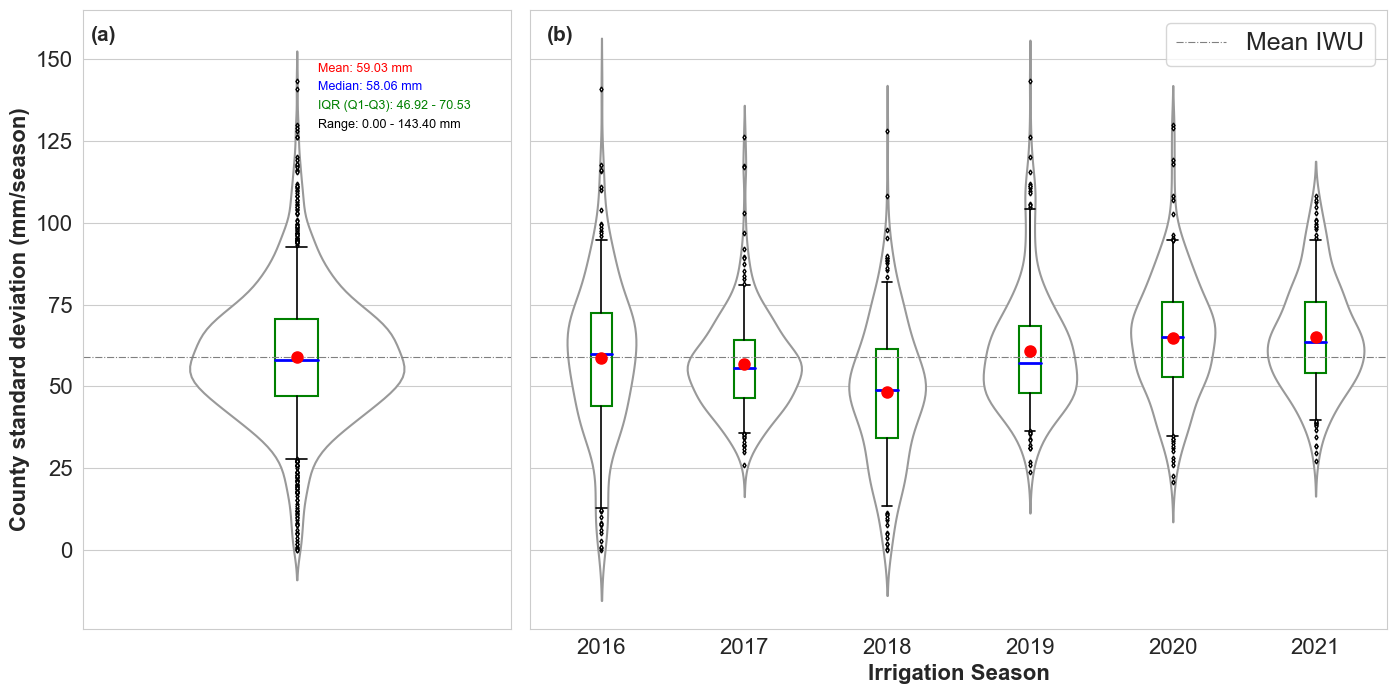

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Define color properties
violin_color = '#ffffff'  # White
boxplot_edge_color = 'green'  # Boxplot outline
boxplot_fill_color = 'white'
mean_marker_color = 'red'
outlier_marker_color = 'black'
median_line_color = 'blue'

# Define the path to the CSV files for the section-year using the wildcard (*) to select multiple files that match the pattern.
section_file = 'G:/001Project/Output/Sheets/cleaned_Results/irrigation_wUse/Section_IWU_*.csv'

# Function to process data and return combined DataFrame
def process_data(file_pattern, groupby_column='COUNTY'):
    all_data = []
    for file in glob.glob(file_pattern):
        # Extract the year from the file name
        year = file.split('_')[-1].split('.')[0]

        data = pd.read_csv(file)
        model_columns = ['DISALEXI_DAYMET', 'EEMETRIC_DAYMET', 'GEESEBAL_DAYMET', 'PTJPL_DAYMET', 'SIMS_DAYMET', 'SSEBOP_DAYMET',
                         'DISALEXI_gridMET', 'EEMETRIC_gridMET', 'GEESEBAL_gridMET', 'PTJPL_gridMET', 'SIMS_gridMET', 'SSEBOP_gridMET',
                         'DISALEXI_IMERG', 'EEMETRIC_IMERG', 'GEESEBAL_IMERG', 'PTJPL_IMERG', 'SIMS_IMERG', 'SSEBOP_IMERG',
                         'DISALEXI_NLDAS', 'EEMETRIC_NLDAS', 'GEESEBAL_NLDAS', 'PTJPL_NLDAS', 'SIMS_NLDAS', 'SSEBOP_NLDAS',
                         'DISALEXI_PRISM', 'EEMETRIC_PRISM', 'GEESEBAL_PRISM', 'PTJPL_PRISM', 'SIMS_PRISM', 'SSEBOP_PRISM']

        # exclude all values less than 0
        data[model_columns] = data[model_columns].clip(lower=0)

        # Group by STATE and COUNTY to get the average for each county in a state
        data = data.groupby(['STATE', groupby_column])[model_columns].mean().reset_index()

        data['STD'] = data[model_columns].std(axis=1)
        data['Year'] = year
        all_data.append(data)

    return pd.concat(all_data)

# Process data for counties
county_data = process_data(section_file, groupby_column='COUNTY')

fig, axes = plt.subplots(1, 2, figsize=(14.07, 7.04), sharey=True,  gridspec_kw={'width_ratios': [1.5, 3]})

# Plot section variability on (axes[0])
sns.violinplot(y=county_data[county_data['STD'] < 200]['STD'], width=0.5, inner=None, ax=axes[0], color= violin_color, edgecolor='black')#, linewidth=2, facecolor='black', alpha=0.5)
for c in axes[0].collections:
    # Check if it's a PathCollection
    if isinstance(c, matplotlib.collections.PathCollection):
        # Set the edge color
        c.set_edgecolor('black')
        c.set_facecolor('#fffff')
        c.set_alpha(1)

sns.boxplot(data=county_data, y='STD', saturation=0.5, width=0.1, color=boxplot_fill_color, boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker':'o',  # Represent mean by a red "o"
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize':'8'},
            medianprops={'color': median_line_color, 'linewidth': 2}, # Represent median by a blue line
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=axes[0])

axes[0].set_ylabel('County standard deviation (mm/season)', fontweight='bold', fontsize=16)
axes[0].tick_params(labelsize=16, which='both', width=2)
axes[0].text(0.02, 0.95, '(a)', transform=axes[0].transAxes, fontsize=15, fontweight='bold')

# Calculate statistics at the county-level
county_stats = county_data['STD'].describe()
county_mean = county_stats['mean']
county_std = county_stats['std']
county_median = county_stats['50%']  # Equivalent to the median
county_q1 = county_stats['25%']  # First quartile (Q1)
county_q3 = county_stats['75%']  # Third quartile (Q3)
county_min = county_stats['min']  # Minimum value
county_max =county_stats['max']  # Maximum value

# Add labels for mean, interquartile ranges on the top right of the first plot
axes[0].text(0.55, 0.90, f'Mean: {county_mean:.2f} mm', transform=axes[0].transAxes, fontsize=9,  color='red')
axes[0].text(0.55, 0.87, f'Median: {county_median:.2f} mm', transform=axes[0].transAxes, fontsize=9, color='blue')
axes[0].text(0.55, 0.84, f'IQR (Q1-Q3): {county_q1:.2f} - {county_q3:.2f}', transform=axes[0].transAxes, fontsize=9, color='green')
axes[0].text(0.55, 0.81, f'Range: {county_min:.2f} - {county_max:.2f} mm', transform=axes[0].transAxes, fontsize=9, color='black')

# Create a data dictionary for the table
table_data = {
    'Year': ['6 Years'],
    'Data': ['Counties'],
    'Mean': [county_mean],
    'Std': [county_std],
    'Median': [county_median],
    'Q1': [county_q1],
    'Q3': [county_q3]
}

#convert to dataframe
table_df = pd.DataFrame(table_data)
table_df = table_df.round(2)

print(table_df)

# Plot section IWU yearly variability on (axes[1])
sns.violinplot(data=county_data, x='Year', y='STD', inner=None, ax=axes[1], color=violin_color, edgecolor='black')
sns.boxplot(data=county_data, x='Year', y='STD', width=0.15, color=boxplot_fill_color, boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker':'o',  # Represent mean by a red "o"
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize':'8'},
            medianprops={'color': median_line_color, 'linewidth': 2}, # Represent median by a blue line
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=axes[1])

for ax in [axes[0], axes[1]]:
    ax.axhline(y=county_mean, color='grey', linestyle='-.', linewidth=0.8, label='Mean IWU')

axes[1].set_ylabel('')
axes[1].set_xlabel('Irrigation Season', fontweight='bold', fontsize=16)
axes[1].tick_params(labelsize=16, which='both', width=2)
axes[1].text(0.02, 0.95, '(b)', transform=axes[1].transAxes, fontsize=15, fontweight='bold')
plt.legend(fontsize=18)

plt.tight_layout()

# Calculate statistics for county_data
county_stats = county_data.groupby('Year')['STD'].agg(['mean', 'std', 'quantile']).reset_index()
county_stats['Q1'] = county_data.groupby('Year')['STD'].quantile(0.25).values
county_stats['Q2'] = county_data.groupby('Year')['STD'].quantile(0.50).values
county_stats['Q3'] = county_data.groupby('Year')['STD'].quantile(0.75).values

# Create a data dictionary for the table 
table_data = {
    'Year': county_stats['Year'].tolist(),
    'Data': ['Counties'] * len(county_stats),
    'Mean': county_stats['mean'].tolist(),
    'Std': county_stats['std'].tolist(),
    'Median': county_stats['Q2'].tolist(),
    'Q1': county_stats['Q1'].tolist(),
    'Q3': county_stats['Q3'].tolist()
}

table_df = pd.DataFrame(table_data)
table_df = table_df.round(2)

print(table_df)

table_filename = out_dir + 'HPA_section_statistics_years.csv'
table_df.to_csv(table_filename, index=False)

plt.savefig(out_dir + "Fig8_HPA_Section_stats.png", dpi=600, bbox_inches='tight')

## Temporal Aggregation

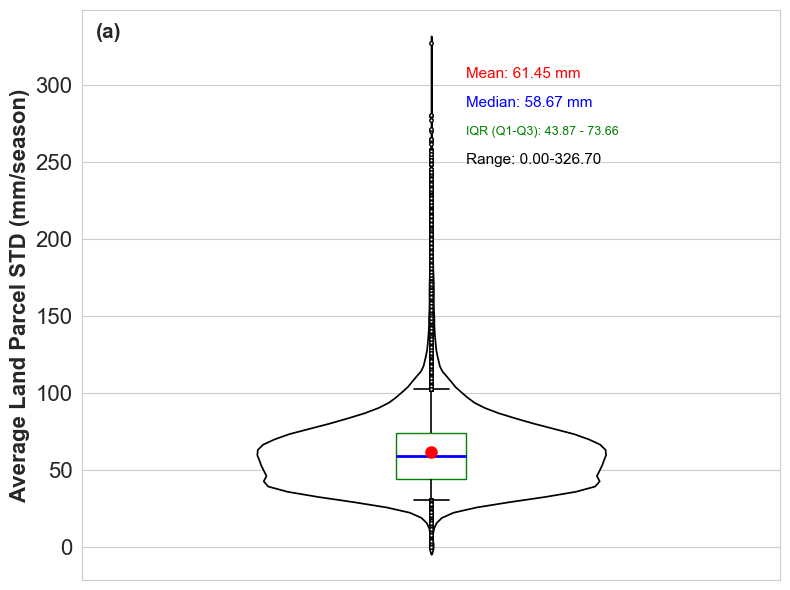

In [8]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define color properties
violin_color = '#ffffff'  # White
boxplot_edge_color = 'green'  # Boxplot outline
boxplot_fill_color = 'white'
mean_marker_color = 'red'
median_line_color = 'blue'

# Define the path to the CSV files for the section-year using the wildcard (*) to select multiple files that match the pattern.
section_file = 'G:/001Project/Output/Sheets/cleaned_Results/irrigation_wUse/Section_IWU_*.csv'
out_dir = 'G:/001Project/Output/Figures/'

# List of models to process
model_columns = [
    'DISALEXI_DAYMET', 'EEMETRIC_DAYMET', 'GEESEBAL_DAYMET', 'PTJPL_DAYMET', 'SIMS_DAYMET', 'SSEBOP_DAYMET',
    'DISALEXI_gridMET', 'EEMETRIC_gridMET', 'GEESEBAL_gridMET', 'PTJPL_gridMET', 'SIMS_gridMET', 'SSEBOP_gridMET',
    'DISALEXI_IMERG', 'EEMETRIC_IMERG', 'GEESEBAL_IMERG', 'PTJPL_IMERG', 'SIMS_IMERG', 'SSEBOP_IMERG',
    'DISALEXI_NLDAS', 'EEMETRIC_NLDAS', 'GEESEBAL_NLDAS', 'PTJPL_NLDAS', 'SIMS_NLDAS', 'SSEBOP_NLDAS',
    'DISALEXI_PRISM', 'EEMETRIC_PRISM', 'GEESEBAL_PRISM', 'PTJPL_PRISM', 'SIMS_PRISM', 'SSEBOP_PRISM'
]

# Process data
def compute_average_across_years(file_pattern):
    # Collect all data from the CSV files
    all_years_data = []
    for file in glob.glob(file_pattern):
        data = pd.read_csv(file)
        data[model_columns] = data[model_columns].clip(lower=0)  # Ensure no negative values
        all_years_data.append(data[model_columns])

    # Compute the average across all years
    average_data = pd.concat(all_years_data).groupby(level=0).mean()

    # Calculate the variability (standard deviation) for the averaged data
    average_data['STD'] = average_data.std(axis=1)
    return average_data

# Compute the averaged data across all 6 years
average_data = compute_average_across_years(section_file)

# Plot the single violin plot for the averaged STD
fig, ax = plt.subplots(figsize=(8, 6))

# Single violin plot for average STD
sns.violinplot(y=average_data['STD'], width=0.5, inner=None, ax=ax, color=violin_color, edgecolor='black')

# Overlay the boxplot for average STD
sns.boxplot(data=average_data, y='STD', saturation=0.5, width=0.1, color=boxplot_fill_color,
            boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker': 'o',  # Represent mean by a red "o"
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize': '8'},
            medianprops={'color': median_line_color, 'linewidth': 2},  # Represent median by a blue line
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=ax)

# Add labels and text
ax.set_ylabel('Average Land Parcel STD (mm/season)', fontweight='bold', fontsize=16)
ax.tick_params(labelsize=16, which='both', width=2)
ax.text(0.02, 0.95, '(a)', transform=ax.transAxes, fontsize=15, fontweight='bold')

# Add statistical summary
avg_stats = average_data['STD'].describe()
avg_mean = avg_stats['mean']
avg_median = avg_stats['50%']
avg_q1 = avg_stats['25%']
avg_q3 = avg_stats['75%']
avg_min = avg_stats['min']
avg_max = avg_stats['max']

ax.text(0.55, 0.88, f'Mean: {avg_mean:.2f} mm', transform=ax.transAxes, fontsize=11, color='red')
ax.text(0.55, 0.83, f'Median: {avg_median:.2f} mm', transform=ax.transAxes, fontsize=11, color='blue')
ax.text(0.55, 0.78, f'IQR (Q1-Q3): {avg_q1:.2f} - {avg_q3:.2f}', transform=ax.transAxes, fontsize=9, color='green')
ax.text(0.55, 0.73, f'Range: {avg_min:.2f}-{avg_max:.2f}', transform=ax.transAxes, fontsize=11, color='black')

plt.tight_layout()
#plt.savefig(out_dir + "Fig1_Avg_STD_Violin.png", dpi=600, bbox_inches='tight')
plt.show()


## Spatial and Temporal Aggregation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


      Year      Data   Mean    Std  Median     Q1     Q3
0  6 Years  Counties  51.11  15.75   49.78  39.18  61.18


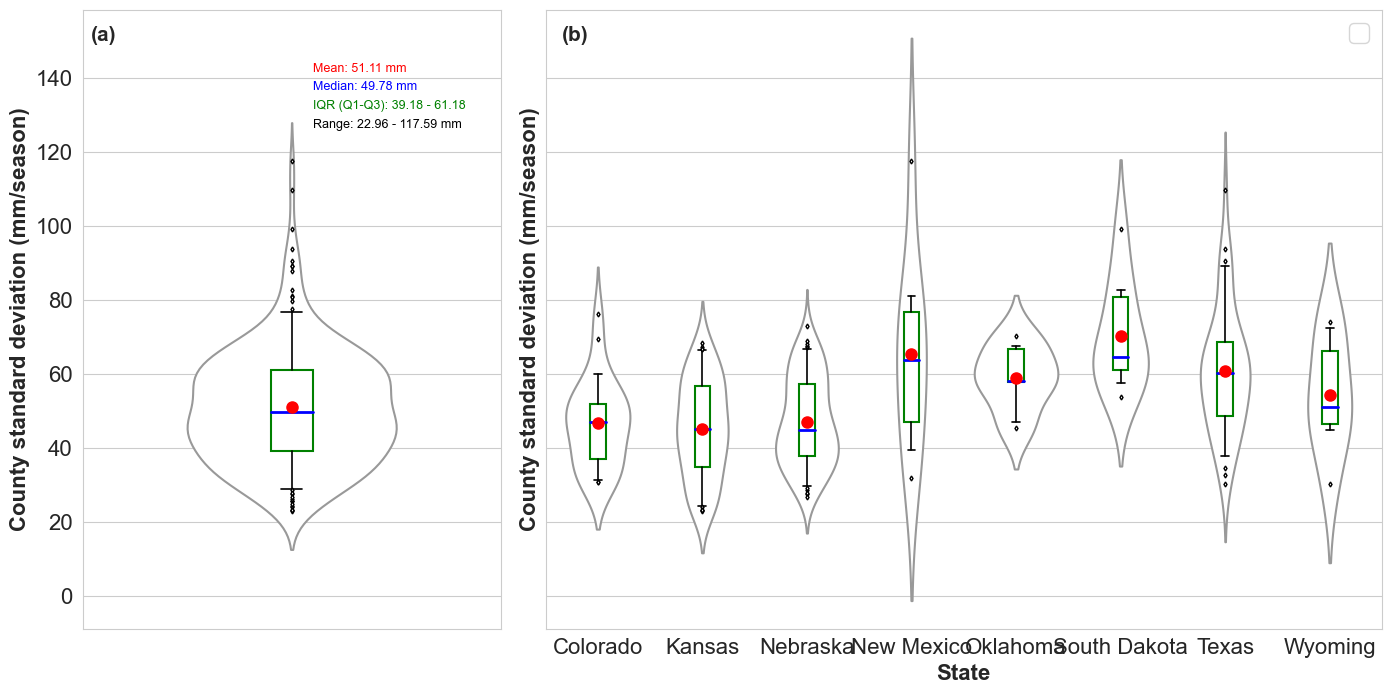

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Define color properties
violin_color = '#ffffff'  # White
boxplot_edge_color = 'green'  # Boxplot outline
boxplot_fill_color = 'white'
mean_marker_color = 'red'
outlier_marker_color = 'black'
median_line_color = 'blue'

# Define the path to the CSV files for the section-year using the wildcard (*) to select multiple files that match the pattern.
section_file = 'G:/001Project/Output/Sheets/cleaned_Results/irrigation_wUse/Section_IWU_*.csv'

# Function to process data and return combined DataFrame
def process_data(file_pattern, groupby_column='COUNTY'):
    all_data = []
    for file in glob.glob(file_pattern):
        data = pd.read_csv(file)
        model_columns = ['DISALEXI_DAYMET', 'EEMETRIC_DAYMET', 'GEESEBAL_DAYMET', 'PTJPL_DAYMET', 'SIMS_DAYMET', 'SSEBOP_DAYMET',
                         'DISALEXI_gridMET', 'EEMETRIC_gridMET', 'GEESEBAL_gridMET', 'PTJPL_gridMET', 'SIMS_gridMET', 'SSEBOP_gridMET',
                         'DISALEXI_IMERG', 'EEMETRIC_IMERG', 'GEESEBAL_IMERG', 'PTJPL_IMERG', 'SIMS_IMERG', 'SSEBOP_IMERG',
                         'DISALEXI_NLDAS', 'EEMETRIC_NLDAS', 'GEESEBAL_NLDAS', 'PTJPL_NLDAS', 'SIMS_NLDAS', 'SSEBOP_NLDAS',
                         'DISALEXI_PRISM', 'EEMETRIC_PRISM', 'GEESEBAL_PRISM', 'PTJPL_PRISM', 'SIMS_PRISM', 'SSEBOP_PRISM']

        # exclude all values less than 0
        data[model_columns] = data[model_columns].clip(lower=0)

        # Group by STATE and COUNTY to get the average for each county in a state
        data = data.groupby(['STATE', groupby_column])[model_columns].mean().reset_index()

        all_data.append(data)

    # Concatenate all yearly data into one DataFrame
    combined_data = pd.concat(all_data)

    # Now, group by STATE and COUNTY again to calculate the average across the years
    combined_data = combined_data.groupby(['STATE', groupby_column])[model_columns].mean().reset_index()

    # Calculate the standard deviation across the model columns for each county
    combined_data['STD'] = combined_data[model_columns].std(axis=1)

    return combined_data

# Process data for counties
county_data = process_data(section_file, groupby_column='COUNTY')

fig, axes = plt.subplots(1, 2, figsize=(14.07, 7.04), sharey=True, gridspec_kw={'width_ratios': [1.5, 3]})

# Plot section variability on (axes[0])
sns.violinplot(y=county_data['STD'], width=0.5, inner=None, ax=axes[0], color=violin_color, edgecolor='black')
sns.boxplot(data=county_data, y='STD', saturation=0.5, width=0.1, color=boxplot_fill_color, boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker':'o',  # Represent mean by a red "o"
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize':'8'},
            medianprops={'color': median_line_color, 'linewidth': 2}, # Represent median by a blue line
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=axes[0])

axes[0].set_ylabel('County standard deviation (mm/season)', fontweight='bold', fontsize=16)
axes[0].tick_params(labelsize=16, which='both', width=2)
axes[0].text(0.02, 0.95, '(a)', transform=axes[0].transAxes, fontsize=15, fontweight='bold')

# Calculate statistics at the county-level
county_stats = county_data['STD'].describe()
county_mean = county_stats['mean']
county_std = county_stats['std']
county_median = county_stats['50%']  # Equivalent to the median
county_q1 = county_stats['25%']  # First quartile (Q1)
county_q3 = county_stats['75%']  # Third quartile (Q3)
county_min = county_stats['min']  # Minimum value
county_max = county_stats['max']  # Maximum value

# Add labels for mean, interquartile ranges on the top right of the first plot
axes[0].text(0.55, 0.90, f'Mean: {county_mean:.2f} mm', transform=axes[0].transAxes, fontsize=9,  color='red')
axes[0].text(0.55, 0.87, f'Median: {county_median:.2f} mm', transform=axes[0].transAxes, fontsize=9, color='blue')
axes[0].text(0.55, 0.84, f'IQR (Q1-Q3): {county_q1:.2f} - {county_q3:.2f}', transform=axes[0].transAxes, fontsize=9, color='green')
axes[0].text(0.55, 0.81, f'Range: {county_min:.2f} - {county_max:.2f} mm', transform=axes[0].transAxes, fontsize=9, color='black')

# Create a data dictionary for the table
table_data = {
    'Year': ['6 Years'],
    'Data': ['Counties'],
    'Mean': [county_mean],
    'Std': [county_std],
    'Median': [county_median],
    'Q1': [county_q1],
    'Q3': [county_q3]
}

# Convert to DataFrame
table_df = pd.DataFrame(table_data)
table_df = table_df.round(2)

print(table_df)

# Plot section IWU yearly variability on (axes[1])
sns.violinplot(data=county_data, x='STATE', y='STD', inner=None, ax=axes[1], color=violin_color, edgecolor='black')
sns.boxplot(data=county_data, x='STATE', y='STD', width=0.15, color=boxplot_fill_color, boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker':'o',  # Represent mean by a red "o"
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize':'8'},
            medianprops={'color': median_line_color, 'linewidth': 2}, # Represent median by a blue line
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=axes[1])

axes[1].set_ylabel('County standard deviation (mm/season)', fontweight='bold', fontsize=16)
axes[1].set_xlabel('State', fontweight='bold', fontsize=16)
axes[1].tick_params(labelsize=16, which='both', width=2)
axes[1].text(0.02, 0.95, '(b)', transform=axes[1].transAxes, fontsize=15, fontweight='bold')
plt.legend(fontsize=18)

plt.tight_layout()

# Save the table and figure
#table_filename = 'HPA_section_statistics_combined_years.csv'
#table_df.to_csv(table_filename, index=False)

#plt.savefig("Fig8_HPA_Section_stats_combined_years.png", dpi=600, bbox_inches='tight')


       Data   Mean    Std  Median     Q1     Q3
0  Sections  61.45  25.06   58.67  43.87  73.66


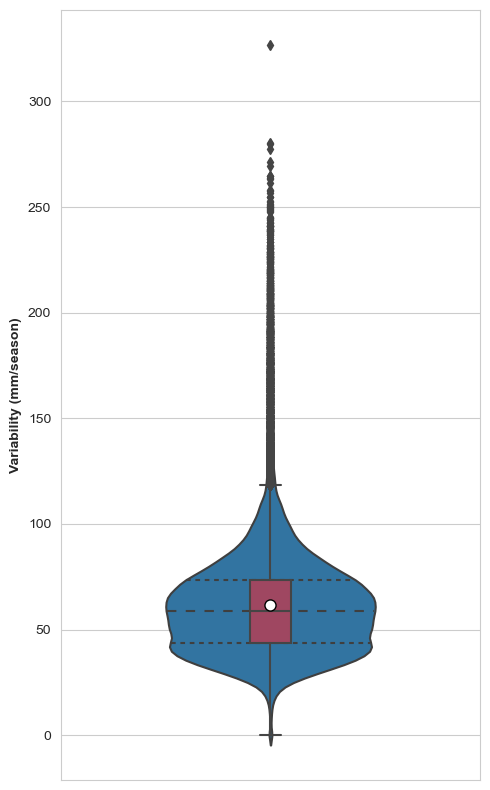

In [4]:
# Define the path to the CSV files for the section-year using the wildcard (*) to select multiple files that match the pattern.
section_file = 'G:/001Project/Output/Sheets/cleaned_Results/irrigation_wUse/Section_IWU_*.csv'

# Function to process data and return a combined DataFrame.
# Parameters:
# - file_pattern: A string representing the pattern to match files.
# - groupby_column: Optional; column name to group the data by, default is None.
def process_data(file_pattern, groupby_column=None):
    years_count = 0  # Initialize a counter for the number of years processed.
    accumulated_data = None  # Initialize a variable to accumulate data across files.

    # Loop over each file that matches the given file pattern.
    for file in glob.glob(file_pattern):
        data = pd.read_csv(file)  # Read the CSV file into a DataFrame.

        # List of columns representing different models and their respective irrigation water use data.
        model_columns = ['DISALEXI_DAYMET', 'EEMETRIC_DAYMET', 'GEESEBAL_DAYMET', 'PTJPL_DAYMET', 'SIMS_DAYMET', 'SSEBOP_DAYMET',
                         'DISALEXI_gridMET', 'EEMETRIC_gridMET', 'GEESEBAL_gridMET', 'PTJPL_gridMET', 'SIMS_gridMET', 'SSEBOP_gridMET',
                         'DISALEXI_IMERG', 'EEMETRIC_IMERG', 'GEESEBAL_IMERG', 'PTJPL_IMERG', 'SIMS_IMERG', 'SSEBOP_IMERG',
                         'DISALEXI_NLDAS', 'EEMETRIC_NLDAS', 'GEESEBAL_NLDAS', 'PTJPL_NLDAS', 'SIMS_NLDAS', 'SSEBOP_NLDAS',
                         'DISALEXI_PRISM', 'EEMETRIC_PRISM', 'GEESEBAL_PRISM', 'PTJPL_PRISM', 'SIMS_PRISM', 'SSEBOP_PRISM']

        # Clip the values in the model columns to ensure no negative values.
        data[model_columns] = data[model_columns].clip(lower=0)

        # If a groupby_column is provided, group the data by this column and compute the mean for each group.
        if groupby_column:
            data = data.groupby(groupby_column)[model_columns].mean().reset_index()

        # If accumulated_data is None, set it to the current data, otherwise accumulate the data.
        if accumulated_data is None:
            accumulated_data = data
        else:
            accumulated_data[model_columns] += data[model_columns]

        years_count += 1  # Increment the year counter.

    # Compute the average of the accumulated data over the number of years processed.
    accumulated_data[model_columns] /= years_count

    # Calculate the standard deviation across the model columns for each row and add it as a new column 'STD'.
    accumulated_data['STD'] = accumulated_data[model_columns].std(axis=1)

    return accumulated_data  # Return the final accumulated and processed DataFrame.

# Process data for sections using the defined function.
# No grouping is applied (groupby_column is None).
section_data = process_data(section_file, groupby_column=None)

# Create a plot to visualize the distribution of the standard deviation ('STD') values.
plt.figure(figsize=(5, 8))

# Violin plot to show the distribution of 'STD' for values less than 200, including quartiles.
sns.violinplot(y=section_data[section_data['STD'] < 200]['STD'], width=0.5, inner='quartile')

# Boxplot overlayed on the violin plot to show key statistics such as the mean.
sns.boxplot(data=section_data, y='STD', saturation=0.5, width=0.1, palette='rocket', boxprops={'zorder': 2}, showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'white',
                       'markeredgecolor':'black',
                       'markersize':'8'})
plt.ylabel('Variability (mm/season)', fontweight='bold')  # Label the y-axis.

# Uncomment the following lines to add a title and save the figure.
# plt.suptitle('Inter-model variability in IWU estimates \n across land parcels in the HPA', fontweight='bold', fontsize=15)
# plt.savefig(out_dir + "Fig2_HPA_Temporal_Aggregation.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

# Calculate descriptive statistics for the 'STD' column.
section_stats = section_data['STD'].describe()
section_mean = section_stats['mean']  # Mean of the standard deviation.
section_std = section_stats['std']  # Standard deviation of the standard deviation.
section_median = section_stats['50%']  # Median of the standard deviation.
section_q1 = section_stats['25%']  # First quartile (Q1) of the standard deviation.
section_q3 = section_stats['75%']  # Third quartile (Q3) of the standard deviation.

# Create a DataFrame to store the calculated statistics in a tabular format.
table_data = {
    'Data': ['Sections'],
    'Mean': [section_mean],
    'Std': [section_std],
    'Median': [section_median],
    'Q1': [section_q1],
    'Q3': [section_q3]
}

table_df = pd.DataFrame(table_data)  # Convert the dictionary to a DataFrame.
table_df = table_df.round(2)  # Round the statistics to two decimal places.
print(table_df)  # Print the final table.


In [6]:
shapefile_path = "G:/001Project/Output/Boundary/Field_Boundary/Irrigated_Croplands/HPA_Irr_Croplands_2017.shp"

# Read the shapefile using geopandas
shp_file = gpd.read_file(shapefile_path)


# Merge data DataFrame with shp_file GeoDataFrame based on "LN_ID" column
merged_data = shp_file.merge(section_data[['LN_ID', 'STD']], left_on='LN_ID', right_on='LN_ID') # section_data from previous process

# Calculate the percentiles of the 'STD' column
p25, p50, p75 = np.percentile(merged_data['STD'], [25, 50, 75])

# Create a new column based on the percentiles
merged_data['variability'] = pd.cut(merged_data['STD'], 
                                    bins=[-np.inf, p25, p50, p75, np.inf], 
                                    labels=['low', 'medium', 'high', 'very high'])

# Create a grid for the figure
fig = plt.figure(figsize=(12, 10))

gs = gridspec.GridSpec(5, 2)#,  width_ratios=(2, 3), height_ratios=(3, 1.5),
                      # left=0.1, right=0.9, bottom=0.1, top=0.9,
                      # wspace=0.1, hspace=0.15)

# Assign the larger subplot for the map
ax_map = plt.subplot(gs[0:4, 0])
merged_data.plot(column='variability', 
                 cmap=matplotlib.colors.ListedColormap(['green', 'yellow', 'orange', 'red']),
                 linewidth=0.01, ax=ax_map, edgecolor='0.1', legend=True, legend_kwds={'loc': 'lower right'})

ax_map.set_title('Variability in irrigation water use estimates \n across land parcels within the HPA', fontweight='bold')
ax_map.spines['left'].set_visible(True)
ax_map.spines['bottom'].set_visible(True)

# Latitude plot: Compute mean of standard deviations using centroids for each unique latitude, then apply a rolling window
lat_mean_std = merged_data.groupby(merged_data.geometry.centroid.x)['STD'].median().rolling(window=3000).mean()
ax_lat = plt.subplot(gs[0:2, 1])
lat_mean_std.plot(ax=ax_lat)
ax_lat.set_title('Zonal Median of variability in IWU', fontweight='bold')
ax_lat.grid(False)
ax_lat.set_xlabel('Longitude', fontweight='bold')
ax_lat.set_ylabel('Median of STD (mm/season)', fontweight='bold')

# Assign the smaller subplot for the PDF
ax_pdf = plt.subplot(gs[2:4, 1])
sns.kdeplot(merged_data['STD'], ax=ax_pdf, shade=True, color='blue')
for percentile in [p25, p50, p75]:
    ax_pdf.axvline(x=percentile, color='red', linestyle='--')
ax_pdf.set_title('Distribution of the variability in IWU', fontweight='bold')
ax_pdf.grid(False)
ax_pdf.set_xlabel('Mean of STD (mm/season)', fontweight='bold')

plt.tight_layout()

#plt.savefig(out_dir + "Fig2_HPA_Temporal_Aggregation.png", dpi=300, bbox_inches='tight')
plt.show()

      Year      Data   Mean    Std  Median     Q1     Q3
0  6 Years  Counties  51.11  15.75   49.78  39.18  61.18


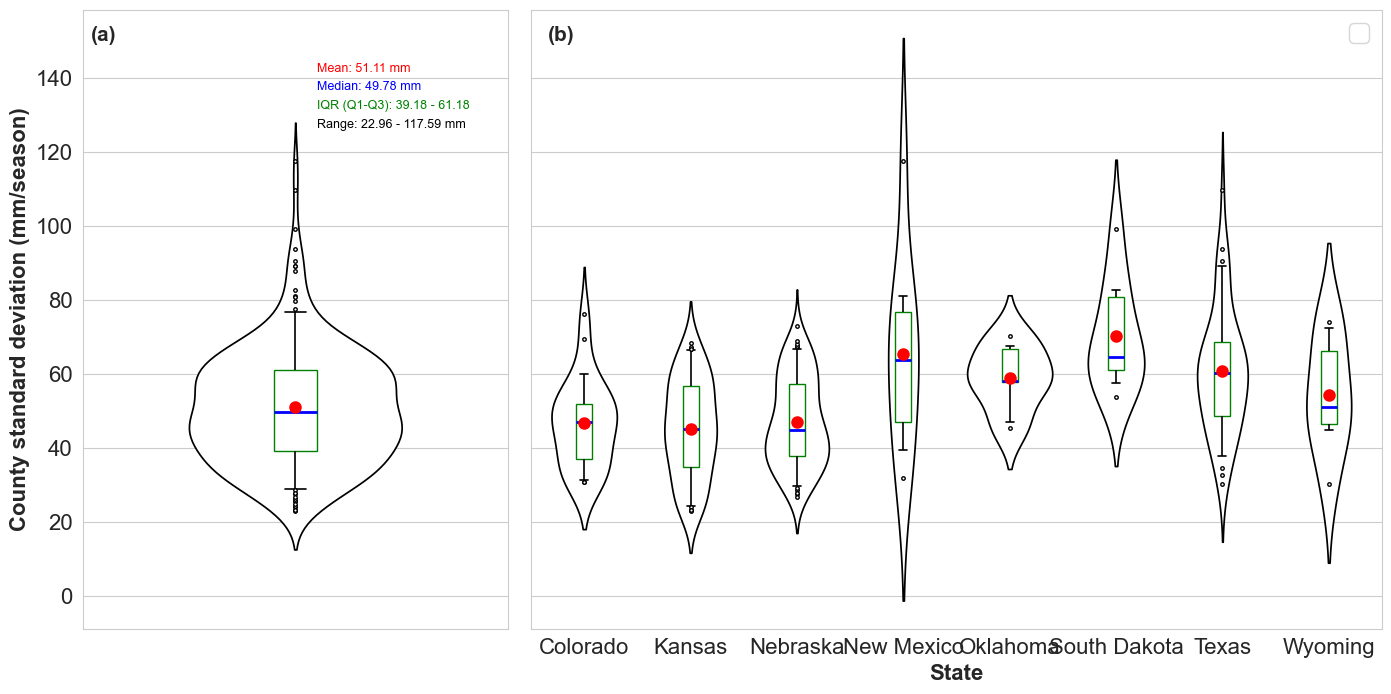

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Define color properties
violin_color = '#ffffff'  # White
boxplot_edge_color = 'green'  # Boxplot outline
boxplot_fill_color = 'white'
mean_marker_color = 'red'
outlier_marker_color = 'black'
median_line_color = 'blue'

# Define the path to the CSV files for the section-year using the wildcard (*) to select multiple files that match the pattern.
section_file = 'G:/001Project/Output/Sheets/cleaned_Results/irrigation_wUse/Section_IWU_*.csv'

# Function to process data and return combined DataFrame
def process_data(file_pattern, groupby_column='COUNTY'):
    all_data = []
    for file in glob.glob(file_pattern):
        data = pd.read_csv(file)
        model_columns = ['DISALEXI_DAYMET', 'EEMETRIC_DAYMET', 'GEESEBAL_DAYMET', 'PTJPL_DAYMET', 'SIMS_DAYMET', 'SSEBOP_DAYMET',
                         'DISALEXI_gridMET', 'EEMETRIC_gridMET', 'GEESEBAL_gridMET', 'PTJPL_gridMET', 'SIMS_gridMET', 'SSEBOP_gridMET',
                         'DISALEXI_IMERG', 'EEMETRIC_IMERG', 'GEESEBAL_IMERG', 'PTJPL_IMERG', 'SIMS_IMERG', 'SSEBOP_IMERG',
                         'DISALEXI_NLDAS', 'EEMETRIC_NLDAS', 'GEESEBAL_NLDAS', 'PTJPL_NLDAS', 'SIMS_NLDAS', 'SSEBOP_NLDAS',
                         'DISALEXI_PRISM', 'EEMETRIC_PRISM', 'GEESEBAL_PRISM', 'PTJPL_PRISM', 'SIMS_PRISM', 'SSEBOP_PRISM']

        # exclude all values less than 0
        data[model_columns] = data[model_columns].clip(lower=0)

        # Group by STATE and COUNTY to get the average for each county in a state
        data = data.groupby(['STATE', groupby_column])[model_columns].mean().reset_index()

        all_data.append(data)

    # Concatenate all yearly data into one DataFrame
    combined_data = pd.concat(all_data)

    # Now, group by STATE and COUNTY again to calculate the average across the years
    combined_data = combined_data.groupby(['STATE', groupby_column])[model_columns].mean().reset_index()

    # Calculate the standard deviation across the model columns for each county
    combined_data['STD'] = combined_data[model_columns].std(axis=1)

    return combined_data

# Process data for counties
county_data = process_data(section_file, groupby_column='COUNTY')

fig, axes = plt.subplots(1, 2, figsize=(14.07, 7.04), sharey=True, gridspec_kw={'width_ratios': [1.5, 3]})

# Plot section variability on (axes[0])
sns.violinplot(y=county_data['STD'], width=0.5, inner=None, ax=axes[0], color=violin_color, edgecolor='black')
sns.boxplot(data=county_data, y='STD', saturation=0.5, width=0.1, color=boxplot_fill_color, boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker':'o',  # Represent mean by a red "o"
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize':'8'},
            medianprops={'color': median_line_color, 'linewidth': 2}, # Represent median by a blue line
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=axes[0])

axes[0].set_ylabel('County standard deviation (mm/season)', fontweight='bold', fontsize=16)
axes[0].tick_params(labelsize=16, which='both', width=2)
axes[0].text(0.02, 0.95, '(a)', transform=axes[0].transAxes, fontsize=15, fontweight='bold')

# Calculate statistics at the county-level
county_stats = county_data['STD'].describe()
county_mean = county_stats['mean']
county_std = county_stats['std']
county_median = county_stats['50%']  # Equivalent to the median
county_q1 = county_stats['25%']  # First quartile (Q1)
county_q3 = county_stats['75%']  # Third quartile (Q3)
county_min = county_stats['min']  # Minimum value
county_max = county_stats['max']  # Maximum value

# Add labels for mean, interquartile ranges on the top right of the first plot
axes[0].text(0.55, 0.90, f'Mean: {county_mean:.2f} mm', transform=axes[0].transAxes, fontsize=9,  color='red')
axes[0].text(0.55, 0.87, f'Median: {county_median:.2f} mm', transform=axes[0].transAxes, fontsize=9, color='blue')
axes[0].text(0.55, 0.84, f'IQR (Q1-Q3): {county_q1:.2f} - {county_q3:.2f}', transform=axes[0].transAxes, fontsize=9, color='green')
axes[0].text(0.55, 0.81, f'Range: {county_min:.2f} - {county_max:.2f} mm', transform=axes[0].transAxes, fontsize=9, color='black')

# Create a data dictionary for the table
table_data = {
    'Year': ['6 Years'],
    'Data': ['Counties'],
    'Mean': [county_mean],
    'Std': [county_std],
    'Median': [county_median],
    'Q1': [county_q1],
    'Q3': [county_q3]
}

# Convert to DataFrame
table_df = pd.DataFrame(table_data)
table_df = table_df.round(2)

print(table_df)

# Plot section IWU yearly variability on (axes[1])
sns.violinplot(data=county_data, x='STATE', y='STD', inner=None, ax=axes[1], color=violin_color, edgecolor='black')
sns.boxplot(data=county_data, x='STATE', y='STD', width=0.15, color=boxplot_fill_color, boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker':'o',  # Represent mean by a red "o"
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize':'8'},
            medianprops={'color': median_line_color, 'linewidth': 2}, # Represent median by a blue line
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=axes[1])

axes[1].set_ylabel('County standard deviation (mm/season)', fontweight='bold', fontsize=16)
axes[1].set_xlabel('State', fontweight='bold', fontsize=16)
axes[1].tick_params(labelsize=16, which='both', width=2)
axes[1].text(0.02, 0.95, '(b)', transform=axes[1].transAxes, fontsize=15, fontweight='bold')
plt.legend(fontsize=18)

plt.tight_layout()

# Save the table and figure
#table_filename = 'HPA_section_statistics_combined_years.csv'
#table_df.to_csv(table_filename, index=False)

#plt.savefig("Fig8_HPA_Section_stats_combined_years.png", dpi=600, bbox_inches='tight')


## Temporal Aggregation

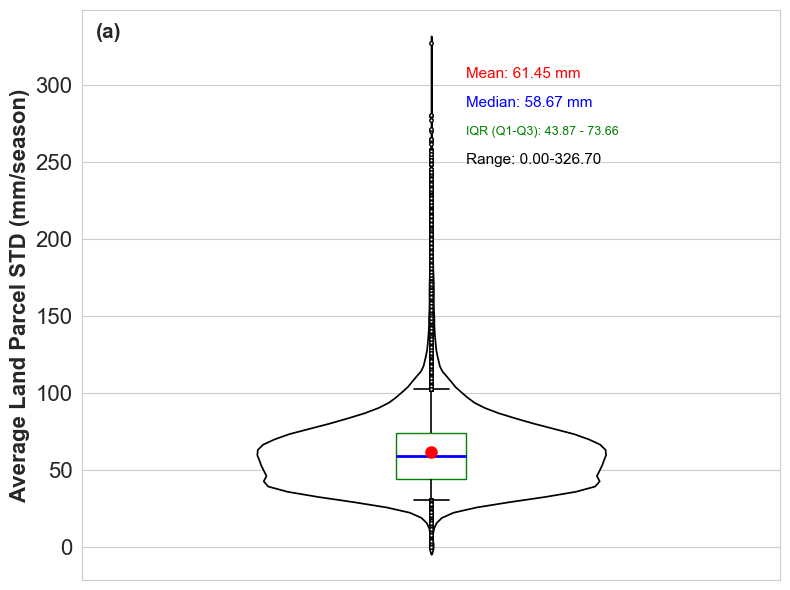

In [6]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define color properties
violin_color = '#ffffff'  # White
boxplot_edge_color = 'green'  # Boxplot outline
boxplot_fill_color = 'white'
mean_marker_color = 'red'
median_line_color = 'blue'

# Define the path to the CSV files for the section-year using the wildcard (*) to select multiple files that match the pattern.
section_file = 'G:/001Project/Output/Sheets/cleaned_Results/irrigation_wUse/Section_IWU_*.csv'
out_dir = 'G:/001Project/Output/Figures/'

# List of models to process
model_columns = [
    'DISALEXI_DAYMET', 'EEMETRIC_DAYMET', 'GEESEBAL_DAYMET', 'PTJPL_DAYMET', 'SIMS_DAYMET', 'SSEBOP_DAYMET',
    'DISALEXI_gridMET', 'EEMETRIC_gridMET', 'GEESEBAL_gridMET', 'PTJPL_gridMET', 'SIMS_gridMET', 'SSEBOP_gridMET',
    'DISALEXI_IMERG', 'EEMETRIC_IMERG', 'GEESEBAL_IMERG', 'PTJPL_IMERG', 'SIMS_IMERG', 'SSEBOP_IMERG',
    'DISALEXI_NLDAS', 'EEMETRIC_NLDAS', 'GEESEBAL_NLDAS', 'PTJPL_NLDAS', 'SIMS_NLDAS', 'SSEBOP_NLDAS',
    'DISALEXI_PRISM', 'EEMETRIC_PRISM', 'GEESEBAL_PRISM', 'PTJPL_PRISM', 'SIMS_PRISM', 'SSEBOP_PRISM'
]

# Process data
def compute_average_across_years(file_pattern):
    # Collect all data from the CSV files
    all_years_data = []
    for file in glob.glob(file_pattern):
        data = pd.read_csv(file)
        data[model_columns] = data[model_columns].clip(lower=0)  # Ensure no negative values
        all_years_data.append(data[model_columns])

    # Compute the average across all years
    average_data = pd.concat(all_years_data).groupby(level=0).mean()

    # Calculate the variability (standard deviation) for the averaged data
    average_data['STD'] = average_data.std(axis=1)
    return average_data

# Compute the averaged data across all 6 years
average_data = compute_average_across_years(section_file)

# Plot the single violin plot for the averaged STD
fig, ax = plt.subplots(figsize=(8, 6))

# Single violin plot for average STD
sns.violinplot(y=average_data['STD'], width=0.5, inner=None, ax=ax, color=violin_color, edgecolor='black')

# Overlay the boxplot for average STD
sns.boxplot(data=average_data, y='STD', saturation=0.5, width=0.1, color=boxplot_fill_color,
            boxprops={'zorder': 2, 'edgecolor': boxplot_edge_color}, showmeans=True,
            meanprops={'marker': 'o',  # Represent mean by a red "o"
                       'markerfacecolor': mean_marker_color,
                       'markeredgecolor': mean_marker_color,
                       'markersize': '8'},
            medianprops={'color': median_line_color, 'linewidth': 2},  # Represent median by a blue line
            whiskerprops={'color': 'black', 'linewidth': 1.2},
            capprops={'color': 'black', 'linewidth': 1.2},
            whis=[5, 95],
            flierprops={'markeredgecolor': 'black', 'markerfacecolor': 'white', 'markersize': 2.5},
            ax=ax)

# Add labels and text
ax.set_ylabel('Average Land Parcel STD (mm/season)', fontweight='bold', fontsize=16)
ax.tick_params(labelsize=16, which='both', width=2)
ax.text(0.02, 0.95, '(a)', transform=ax.transAxes, fontsize=15, fontweight='bold')

# Add statistical summary
avg_stats = average_data['STD'].describe()
avg_mean = avg_stats['mean']
avg_median = avg_stats['50%']
avg_q1 = avg_stats['25%']
avg_q3 = avg_stats['75%']
avg_min = avg_stats['min']
avg_max = avg_stats['max']

ax.text(0.55, 0.88, f'Mean: {avg_mean:.2f} mm', transform=ax.transAxes, fontsize=11, color='red')
ax.text(0.55, 0.83, f'Median: {avg_median:.2f} mm', transform=ax.transAxes, fontsize=11, color='blue')
ax.text(0.55, 0.78, f'IQR (Q1-Q3): {avg_q1:.2f} - {avg_q3:.2f}', transform=ax.transAxes, fontsize=9, color='green')
ax.text(0.55, 0.73, f'Range: {avg_min:.2f}-{avg_max:.2f}', transform=ax.transAxes, fontsize=11, color='black')

plt.tight_layout()
#plt.savefig(out_dir + "Fig1_Avg_STD_Violin.png", dpi=600, bbox_inches='tight')
plt.show()


In [7]:
average_data

,DISALEXI_DAYMET,EEMETRIC_DAYMET,GEESEBAL_DAYMET,PTJPL_DAYMET,SIMS_DAYMET,SSEBOP_DAYMET,DISALEXI_gridMET,EEMETRIC_gridMET,GEESEBAL_gridMET,PTJPL_gridMET,...,PTJPL_NLDAS,SIMS_NLDAS,SSEBOP_NLDAS,DISALEXI_PRISM,EEMETRIC_PRISM,GEESEBAL_PRISM,PTJPL_PRISM,SIMS_PRISM,SSEBOP_PRISM,STD
0,137.917616,143.371812,107.724482,118.034810,230.069383,96.844104,102.327616,103.514457,66.881149,84.657149,...,128.464827,240.499399,101.757058,110.189003,111.375844,73.576035,91.394202,202.340769,63.598429,48.659152
1,184.769408,278.275148,189.485110,291.392039,452.687165,247.881740,182.378839,275.884580,187.094541,289.001471,...,313.107121,474.402247,269.596821,185.403556,278.909296,190.119258,292.026187,453.321313,248.515888,92.051480
2,294.898809,288.873217,299.178181,336.714402,375.313738,281.941497,285.492727,279.467134,289.772098,327.308319,...,373.881453,412.480789,319.108548,278.579545,272.553953,282.858917,320.395138,358.994474,265.622233,38.935106
3,303.424144,311.587183,270.872934,235.305343,399.895745,289.385967,294.404362,302.567401,261.853152,226.285561,...,259.214000,423.804403,313.294624,298.072904,306.235943,265.521693,229.954102,394.544505,284.034726,52.596626
4,295.922353,390.608503,331.243918,358.625348,488.734256,434.087307,269.696003,364.382153,305.017568,332.398998,...,384.358634,514.467541,459.820592,274.424743,369.110892,309.746308,337.127738,467.236645,412.589697,67.896056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114867,164.683334,231.246318,103.764587,193.088733,337.001423,130.173726,149.805056,216.368039,94.814687,178.210455,...,175.206033,319.118723,123.703201,148.150020,214.713004,94.253255,176.555419,320.468109,118.165621,75.967417
114868,173.104808,271.987546,109.279890,182.097766,300.139857,129.336820,179.236006,278.118744,115.411087,188.228964,...,171.088148,289.130238,113.677228,181.636392,280.519130,117.811473,190.629350,308.671440,134.994162,73.247568
114869,148.426041,234.743677,90.065856,140.608161,272.843922,123.185629,153.745917,242.048130,95.385732,147.912614,...,123.063557,255.299319,109.325996,156.006383,245.671476,97.646198,151.535959,283.771721,130.765970,66.958016
114870,310.616766,486.591897,283.247132,287.006397,413.599026,343.675866,318.698434,494.673565,291.328800,295.088065,...,286.208260,412.800889,342.877729,322.098607,498.073738,294.728973,298.488238,425.080867,355.157707,76.804317
